In [1]:
import os
import numpy as np
import pydicom
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import cv2
import h5py
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchinfo import summary

In [2]:
# Directorio donde están los estudios (cada subcarpeta es un estudio MRI)
dicom_root_dir = './Imagenes_Finales/176X256X256'

# Función para cargar y normalizar un volumen 3D
def load_dicom_volume(dicom_dir):
    dicom_files = sorted([os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith(".dcm")],
                         key=lambda f: float(pydicom.dcmread(f).InstanceNumber))
    
    volume = np.array([pydicom.dcmread(f).pixel_array for f in dicom_files], dtype=np.float32)
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume) + 1e-7)  # Normalización [0,1]
    return volume

In [3]:
# Cargar todos los estudios
study_dirs = [os.path.join(dicom_root_dir, d) for d in os.listdir(dicom_root_dir) if os.path.isdir(os.path.join(dicom_root_dir, d))]
volumes = [load_dicom_volume(study_dir) for study_dir in study_dirs]

In [4]:
print(f"Se cargaron {len(volumes)} estudios.")

Se cargaron 30 estudios.


In [5]:
# Generar baja resolución
def low_res_volume(volume, factor=0.5):
    d, h, w = volume.shape
    low_res = np.array([cv2.resize(cv2.resize(slice, (int(w * factor), int(h * factor)), interpolation=cv2.INTER_AREA),
                                   (w, h), interpolation=cv2.INTER_LINEAR) for slice in volume])
    return low_res

In [6]:
low_res_volumes = [low_res_volume(vol) for vol in volumes]

In [7]:
print(f"Dimensiones del primer volumen HR: {volumes[0].shape}")
print(f"Dimensiones del primer volumen LR: {low_res_volumes[0].shape}")

Dimensiones del primer volumen HR: (176, 256, 256)
Dimensiones del primer volumen LR: (176, 256, 256)


In [8]:
# Visualización de un corte específico
def visualize_slices(original, low_res, slice_idx):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original[slice_idx], cmap='gray')
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(low_res[slice_idx], cmap='gray')
    plt.title("Low Resolution")
    plt.show()

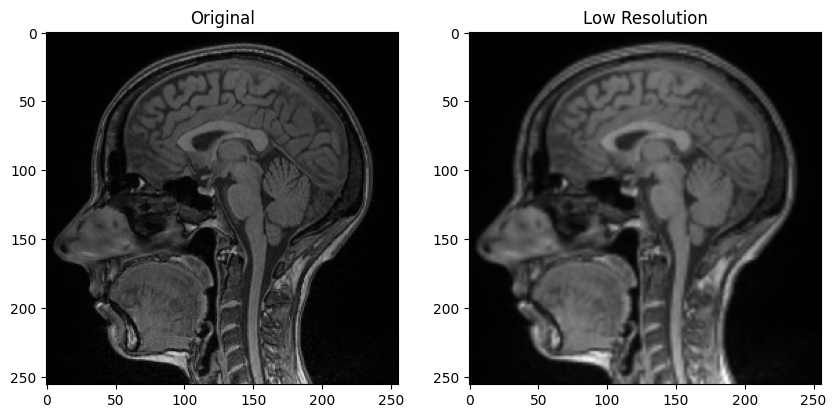

In [9]:
# Elegir un estudio y un corte.
study_idx = 7
slice_idx = volumes[study_idx].shape[0] // 2  # Corte intermedio
visualize_slices(volumes[study_idx], low_res_volumes[study_idx], slice_idx)

In [10]:
# División en entrenamiento y validación
train_vols, val_vols, train_lr, val_lr = train_test_split(volumes, low_res_volumes, test_size=0.1, random_state=42)

In [11]:
# Extraer patches 3D
def extract_patches(volume, patch_size=(64, 64, 64), stride=32):
    d, h, w = volume.shape
    return [volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]
            for z in range(0, d - patch_size[0] + 1, stride)
            for y in range(0, h - patch_size[1] + 1, stride)
            for x in range(0, w - patch_size[2] + 1, stride)]

In [12]:
train_patches = [(p, hr) for vol_lr, vol_hr in zip(train_lr, train_vols) for p, hr in zip(extract_patches(vol_lr), extract_patches(vol_hr))]
val_patches = [(p, hr) for vol_lr, vol_hr in zip(val_lr, val_vols) for p, hr in zip(extract_patches(vol_lr), extract_patches(vol_hr))]

In [13]:
# Dataset
class MRI3DPatchDataset(data.Dataset):
    def __init__(self, patch_pairs):
        self.patch_pairs = patch_pairs
    
    def __len__(self):
        return len(self.patch_pairs)
    
    def __getitem__(self, idx):
        lr_patch, hr_patch = self.patch_pairs[idx]
        return torch.tensor(lr_patch, dtype=torch.float32).unsqueeze(0), torch.tensor(hr_patch, dtype=torch.float32).unsqueeze(0)

In [14]:
dataset_train = MRI3DPatchDataset(train_patches)
dataset_val = MRI3DPatchDataset(val_patches)

In [15]:
# Dataloader
dataloader_train = data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
dataloader_val = data.DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [16]:
# Modelo SRCNN3D
class SRCNN3D(nn.Module):
    def __init__(self):
        super(SRCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(16, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

In [17]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Inicializar modelo 
model = SRCNN3D().to(device)
# Summary del modelo
summary(model, input_size=(1, 1, 64, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN3D                                  [1, 1, 64, 64, 64]        --
├─Conv3d: 1-1                            [1, 64, 64, 64, 64]       46,720
├─ReLU: 1-2                              [1, 64, 64, 64, 64]       --
├─Conv3d: 1-3                            [1, 64, 64, 64, 64]       110,656
├─ReLU: 1-4                              [1, 64, 64, 64, 64]       --
├─Conv3d: 1-5                            [1, 32, 64, 64, 64]       55,328
├─ReLU: 1-6                              [1, 32, 64, 64, 64]       --
├─Conv3d: 1-7                            [1, 16, 64, 64, 64]       13,840
├─ReLU: 1-8                              [1, 16, 64, 64, 64]       --
├─Conv3d: 1-9                            [1, 1, 64, 64, 64]        2,001
Total params: 228,545
Trainable params: 228,545
Non-trainable params: 0
Total mult-adds (G): 59.91
Input size (MB): 1.05
Forward/backward pass size (MB): 371.20
Params size (MB): 0.91
Estimated Total Size 

In [ ]:
# Inicializar función de pérdida, optimizador y scheduler
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [20]:
# Se crea la carpeta para guardar los checkpoints y las metricas
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
# En el archivo h5 se guardan las metricas para realizar graficas posteriormente, sin tener que correr todo el entrenamiento de nuevo
h5_file = os.path.join(checkpoint_dir, "metrics.h5")
with h5py.File(h5_file, "w") as f:
    f.create_dataset("train_loss", (0,), maxshape=(None,))
    f.create_dataset("val_loss", (0,), maxshape=(None,))
    f.create_dataset("psnr_train", (0,), maxshape=(None,))
    f.create_dataset("ssim_train", (0,), maxshape=(None,))
    f.create_dataset("psnr_val", (0,), maxshape=(None,))
    f.create_dataset("ssim_val", (0,), maxshape=(None,))

In [22]:
num_epochs = 50

print("Entrenamiento Iniciado")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_psnr_train, total_ssim_train, count_train = 0, 0, 0

    for lr_patch, hr_patch in dataloader_train:
        lr_patch, hr_patch = lr_patch.to(device), hr_patch.to(device)
        optimizer.zero_grad()

        output = model(lr_patch)
        loss = criterion(output, hr_patch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_size = lr_patch.size(0)

        for i in range(batch_size):
            output_np = output[i].cpu().detach().numpy().squeeze()
            hr_np = hr_patch[i].cpu().detach().numpy().squeeze()
            total_psnr_train += psnr(hr_np, output_np, data_range=1)
            total_ssim_train += ssim(hr_np, output_np, data_range=1)
            count_train += 1

    avg_train_loss = train_loss / len(dataloader_train)
    avg_psnr_train = total_psnr_train / count_train
    avg_ssim_train = total_ssim_train / count_train

    # Validación
    model.eval()
    val_loss = 0.0
    total_psnr_val, total_ssim_val, count_val = 0, 0, 0

    with torch.no_grad():
        for lr_patch, hr_patch in dataloader_val:
            lr_patch, hr_patch = lr_patch.to(device), hr_patch.to(device)
            output = model(lr_patch)
            loss = criterion(output, hr_patch)
            val_loss += loss.item()

            batch_size = lr_patch.size(0)
            for i in range(batch_size):
                output_np = output[i].cpu().detach().numpy().squeeze()
                hr_np = hr_patch[i].cpu().detach().numpy().squeeze()
                total_psnr_val += psnr(hr_np, output_np, data_range=1)
                total_ssim_val += ssim(hr_np, output_np, data_range=1)
                count_val += 1

    avg_val_loss = val_loss / len(dataloader_val)
    avg_psnr_val = total_psnr_val / count_val
    avg_ssim_val = total_ssim_val / count_val

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"PSNR Train: {avg_psnr_train:.2f}, PSNR Val: {avg_psnr_val:.2f}, "
          f"SSIM Train: {avg_ssim_train:.4f}, SSIM Val: {avg_ssim_val:.4f}")

    # Guardar en el archivo HDF5
    with h5py.File(h5_file, "a") as f:
        for key, value in zip(
            ["train_loss", "val_loss", "psnr_train", "ssim_train", "psnr_val", "ssim_val"],
            [avg_train_loss, avg_val_loss, avg_psnr_train, avg_ssim_train, avg_psnr_val, avg_ssim_val]
        ):
            dataset = f[key]
            dataset.resize((dataset.shape[0] + 1,))
            dataset[-1] = value

    # Guardar checkpoint del modelo
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"srcnn3d_epoch_{epoch+1}.pth"))

    # Ajustar el learning rate
    scheduler.step(avg_val_loss)

print("Entrenamiento completado.")




Entrenamiento Iniciado
Epoch [1/50] - Train Loss: 0.0012, Val Loss: 0.0005, PSNR Train: 32.71, PSNR Val: 34.17, SSIM Train: 0.8883, SSIM Val: 0.9420
Epoch [2/50] - Train Loss: 0.0005, Val Loss: 0.0005, PSNR Train: 35.22, PSNR Val: 34.73, SSIM Train: 0.9488, SSIM Val: 0.9483
Epoch [3/50] - Train Loss: 0.0004, Val Loss: 0.0004, PSNR Train: 35.82, PSNR Val: 35.14, SSIM Train: 0.9538, SSIM Val: 0.9511
Epoch [4/50] - Train Loss: 0.0004, Val Loss: 0.0004, PSNR Train: 35.96, PSNR Val: 35.36, SSIM Train: 0.9550, SSIM Val: 0.9527
Epoch [5/50] - Train Loss: 0.0004, Val Loss: 0.0004, PSNR Train: 36.19, PSNR Val: 35.51, SSIM Train: 0.9565, SSIM Val: 0.9543
Epoch [6/50] - Train Loss: 0.0004, Val Loss: 0.0004, PSNR Train: 36.36, PSNR Val: 35.67, SSIM Train: 0.9579, SSIM Val: 0.9550
Epoch [7/50] - Train Loss: 0.0003, Val Loss: 0.0004, PSNR Train: 36.55, PSNR Val: 35.23, SSIM Train: 0.9590, SSIM Val: 0.9553
Epoch [8/50] - Train Loss: 0.0003, Val Loss: 0.0004, PSNR Train: 36.70, PSNR Val: 35.96, SSIM T

In [23]:
# Se guarda el modelo final
save_path = "SRCNN3D_final.pth"

# Guarda los pesos del modelo
torch.save(model.state_dict(), save_path)

print(f"Modelo guardado en {save_path}")

Modelo guardado en SRCNN3D3D_final.pth


EL ENTRENAMIENTO DURO 7 HORAS Y 33 MINUTOS

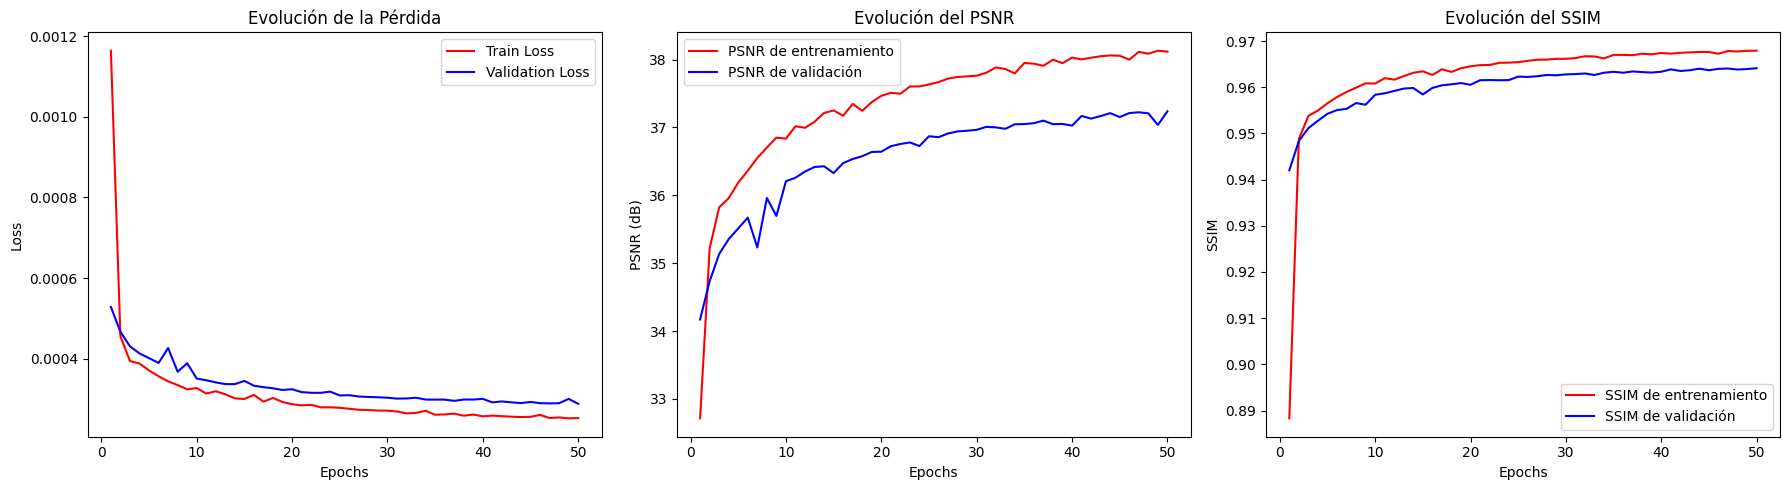

In [24]:
# Leer los datos del archivo HDF5
with h5py.File(h5_file, "r") as f:
    train_losses = f["train_loss"][:]
    val_losses = f["val_loss"][:]
    psnr_train = f["psnr_train"][:]
    psnr_val = f["psnr_val"][:]
    ssim_train = f["ssim_train"][:]
    ssim_val = f["ssim_val"][:]

# Crear el rango de épocas
epochs = range(1, len(train_losses) + 1)

# Graficar las métricas
plt.figure(figsize=(18, 5))

# Gráfico de la función de pérdida
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'r-', label="Train Loss")
plt.plot(epochs, val_losses, 'b-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución de la Pérdida")
plt.legend()

# Gráfico de PSNR
plt.subplot(1, 3, 2)
plt.plot(epochs, psnr_train, 'r-', label="PSNR de entrenamiento")
plt.plot(epochs, psnr_val, 'b-', label="PSNR de validación")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("Evolución del PSNR")
plt.legend()

# Gráfico de SSIM
plt.subplot(1, 3, 3)
plt.plot(epochs, ssim_train, 'r-', label="SSIM de entrenamiento")
plt.plot(epochs, ssim_val, 'b-', label="SSIM de validación")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("Evolución del SSIM")
plt.legend()

plt.tight_layout()
plt.show()